# Introduction

The objective of this notebook is the explore the dataset laws.csv

## Librairies

In [ ]:
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.5 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16677 sha256=f5f7c6bcd10b9b217abe7deccf484197b9f3330b1e5b991df586218e08f7e5d1
  Stored in directory: /root/.cache/pip/wheels/41/01/29/deaa71fe596f8d857e57c4fb388db8861e23e6ed0b03204dcb
Successfully built pandarallel


In [ ]:
%%time
pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 27.2 ms, sys: 15.3 ms, total: 42.5 ms
Wall time: 4.12 s


In [ ]:
import pandas as pd
import polars as pl
import re
import html as html_parser
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from lxml import html
from tqdm import tqdm, notebook
import string
import nltk
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Importing Data

In [ ]:
# from numba import cuda


# cc_cores_per_SM_dict = {
#     (2,0) : 32,
#     (2,1) : 48,
#     (3,0) : 192,
#     (3,5) : 192,
#     (3,7) : 192,
#     (5,0) : 128,
#     (5,2) : 128,
#     (6,0) : 64,
#     (6,1) : 128,
#     (7,0) : 64,
#     (7,5) : 64,
#     (8,0) : 64,
#     (8,6) : 128,
#     (8,9) : 128,
#     (9,0) : 128
#     }
# # the above dictionary should result in a value of "None" if a cc match 
# # is not found.  The dictionary needs to be extended as new devices become
# # available, and currently does not account for all Jetson devices
# device = cuda.get_current_device()
# my_sms = getattr(device, 'MULTIPROCESSOR_COUNT')
# my_cc = device.compute_capability
# cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
# total_cores = cores_per_sm*my_sms
# print("GPU compute capability: " , my_cc)
# print("GPU total number of SMs: " , my_sms)
# print("total cores: " , total_cores)

In [ ]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


With TPU we have 20 workers

In [ ]:
# Set the directory where the corpus files are located
directory = 'drive/MyDrive/ENI/'

df_law = pd.read_csv(f'{directory}laws.csv', memory_map = True)


In [ ]:
df_law.head(2)

,Abstract,Checksum,Datum,HTML.Checksum,HTML.Datei,HTML.URL,Kopfzeile,Meta,Num,Raw,...,ScrapyJob,Signatur,Site,Spider,Sprache,Type,Uri,Zeit UTC,__v,_id
0,"[{""Sprachen"":[""de"",""fr"",""it""],""Text"":""QUALITÉ ...",41b915ce5651fbc4cdeb5326dc2570db,2020-06-19,17ede7694e3e8551bbc70254e5cafaf1,GE_Gerichte/GE_CAPJ_001_CAPJ-01-2020_2020-06-1...,http://justice.ge.ch/apps/decis/fr/capj/show/2...,"[{""Sprachen"":[""de""],""Text"":""Genf Court d'appel...","[{""Sprachen"":[""de""],""Text"":""Genf Court d'appel...","[""CAPJ/01/2020""]","<!DOCTYPE html><html lang=""fr""><head><meta cha...",...,446973/35/762,GE_CAPJ_001,entscheidsuche.ch,GE_Gerichte,fr,case law,https://entscheidsuche.ch/docs/GE_Gerichte/GE_...,23.05.2022 01:09:59,0,63218f363ca37d0db12644a8
1,"[{""Sprachen"":[""de"",""fr"",""it""],""Text"":""Bouwmees...",8a69602465bf223e7014c2389f3a1117,1988-03-04,4d62b887a72ce7bcf3781eef23656deb,VD_Omni/VD_SR_001_09ae0257b929e3edb48e_1988-03...,http://www.jurisprudence.vd.ch/scripts/nph-omn...,"[{""Sprachen"":[""de""],""Text"":""Waadtland Conseil ...","[{""Sprachen"":[""de""],""Text"":""Waadtland Conseil ...","[""""]","<!DOCTYPE html><html lang=""de""><head><meta cha...",...,446973/40/263,VD_SR_001,entscheidsuche.ch,VD_Omni,de,case law,https://entscheidsuche.ch/docs/VD_Omni/VD_SR_0...,11.07.2021 02:43:23,0,63218f363ca37d0db12644aa


In [ ]:
df_law.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92177 entries, 0 to 92176
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Abstract       92177 non-null  object
 1   Checksum       92177 non-null  object
 2   Datum          92177 non-null  object
 3   HTML.Checksum  92177 non-null  object
 4   HTML.Datei     92177 non-null  object
 5   HTML.URL       92177 non-null  object
 6   Kopfzeile      92177 non-null  object
 7   Meta           92177 non-null  object
 8   Num            92177 non-null  object
 9   Raw            92177 non-null  object
 10  RawType        92177 non-null  object
 11  ScrapyJob      92177 non-null  object
 12  Signatur       92177 non-null  object
 13  Site           92177 non-null  object
 14  Spider         92177 non-null  object
 15  Sprache        92177 non-null  object
 16  Type           92177 non-null  object
 17  Uri            92177 non-null  object
 18  Zeit UTC       92177 non-n

In [ ]:
df_law.columns

Index(['Abstract', 'Checksum', 'Datum', 'HTML.Checksum', 'HTML.Datei',
       'HTML.URL', 'Kopfzeile', 'Meta', 'Num', 'Raw', 'RawType', 'ScrapyJob',
       'Signatur', 'Site', 'Spider', 'Sprache', 'Type', 'Uri', 'Zeit UTC',
       '__v', '_id', 'text'],
      dtype='object')

In [ ]:
df_law['Abstract'][0]

'[{"Sprachen":["de","fr","it"],"Text":"QUALITÉ POUR RECOURIR;DÉNONCIATEUR | LPA.60"}]'

What is it ? The Title ? A legend ?

In [ ]:
df_law['Checksum'][0]

'41b915ce5651fbc4cdeb5326dc2570db'

That's the ID of the document ?

In [ ]:
df_law['Datum'][0]

'2020-06-19'

What does that date refer to ?

In [ ]:
df_law['HTML.Checksum'][0]

'17ede7694e3e8551bbc70254e5cafaf1'

What is it ? an ID ?

In [ ]:
df_law['HTML.Datei'][0]

'GE_Gerichte/GE_CAPJ_001_CAPJ-01-2020_2020-06-19.html'

In [ ]:
df_law['Kopfzeile'][0]

'[{"Sprachen":["de"],"Text":"Genf Court d\'appel du pouvoir judiciaire 19.06.2020 CAPJ/01/2020"},{"Sprachen":["fr"],"Text":"Genève Court d\'appel du pouvoir judiciaire 19.06.2020 CAPJ/01/2020"},{"Sprachen":["it"],"Text":"Ginevra Court d\'appel du pouvoir judiciaire 19.06.2020 CAPJ/01/2020"}]'

What does 'Kopfzeile' mean here ?

In [ ]:
df_law['Meta'][0]

'[{"Sprachen":["de"],"Text":"Genf Court d\'appel du pouvoir judiciaire "},{"Sprachen":["fr"],"Text":"Genève Court d\'appel du pouvoir judiciaire "},{"Sprachen":["it"],"Text":"Ginevra Court d\'appel du pouvoir judiciaire "}]'

The Meta column seems similar to the column Kopfzeile

In [ ]:
df_law['Num'][0]

'["CAPJ/01/2020"]'

Another ID ?

'<!DOCTYPE html><html lang="fr"><head><meta charset="utf-8"/></head><!DOCTYPE html><html lang="fr"><head><meta charset="utf-8"/></head><body><div class="list-block col-lg-12 mb-5">\n  <div class="decis-block__flag">\n      CAPJ/01/2020\n\n  </div>\n  <div class="list-block__content row pb-3">\n    <h3 class="list-block__title col-lg-8">\n        <a href="/apps/decis/fr/capj/show/2920474">\n            ACAPJ/2/2020\n\n        </a>          \n      (1)\n      du 19.06.2020\n      \n      ,   Irrecevable\n\n    </h3>\n    \n    <div class="col-lg-12">\n      \n  \n    <div>\n      <b>Descripteurs</b> :\n      QUALITÉ POUR RECOURIR;DÉNONCIATEUR\n    </div>\n\n      \n  \n    <div>\n      <b>Normes</b> :\n      LPA.60\n    </div>\n\n      \n  \n\n      \n  \n\n      \n  \n\n      \n  \n\n  \n      \n    </div>\n\n    <div class="col-lg-12 mt-4">\n      <div style="float:right">\n          <a href="/apps/decis/fr/capj/file//2020/0000/CAPJ_000001_2020_ACAPJ_2_2020.pdf">\n                     
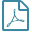

In [ ]:
df_law['Raw'][0]

I guess that is the HTLM documents we will explore I suppose

In [ ]:
df_law['RawType'][0]

'html'

OK....Columns to remove

In [ ]:
df_law['RawType'].unique()

array(['html'], dtype=object)

We only have 'HTLM' in that column

In [ ]:
df_law['ScrapyJob'][0]

'446973/35/762'

What is that ?

In [ ]:
df_law['Signatur'][0]

'GE_CAPJ_001'

Is it useful ?

In [ ]:
df_law['Site'][0]

'entscheidsuche.ch'

In [ ]:
df_law['Spider'][0]

'GE_Gerichte'

Is it useful ?

In [ ]:
df_law['Sprache'][0]

'fr'

That is the language of the document, I guess

In [ ]:
df_law['Sprache'].unique()

array(['fr', 'de', 'it'], dtype=object)

We have 3 languages in our documents, French, Italians and DE

In [ ]:
df_law['Sprache'].value_counts()

fr    91447
de      571
it      159
Name: Sprache, dtype: int64

Most of the documents are in French. 91K where (IT + DE) => 700

In [ ]:
df_law['Type'][0]

'case law'

In [ ]:
df_law['Type'].unique()

array(['case law'], dtype=object)

The documents are only about law cases

In [ ]:
df_law['Uri'][0]

'https://entscheidsuche.ch/docs/GE_Gerichte/GE_CAPJ_001_CAPJ-01-2020_2020-06-19.html'

In [ ]:
df_law['Zeit UTC'][0]

'23.05.2022 01:09:59'

What does it refer to ?

In [ ]:
df_law['__v'][0]

0

In [ ]:
df_law['__v'].unique()

array([0])

In [ ]:
df_law['__v'].sum()

0

What is the point of this column ?

In [ ]:
df_law['_id'][0]

'63218f363ca37d0db12644a8'

Seems like I have many columns with IDs...

I need to process the HTML document so it could be readable, the function below (get_text) do the job

In [ ]:
def get_text(html_string: str) -> str:
    """ Extract the text from an HTML string. """""
 
    parsed_html = html.fromstring(html_string)
    p_tags = parsed_html.xpath('//p') # Find all the <p> tags
    text = ' '.join([p_tag.text_content() for p_tag in p_tags])

    text = html_parser.unescape(text) # Unescape HTML entities
    text = re.sub('\s+', ' ', text) # Remove extra whitespace

    return text


In [ ]:
# @title Trying with Polars
# df_law = df_law.with_columns(pl.col('Raw').apply(lambda x: get_text(x)).alias('text'))

In [ ]:
# data_law = df_law.collect()

Using polars takes too much memory...17.2 go

In [ ]:
# @title Using Pandas
df_law['text'] = df_law['Raw'].parallel_apply(lambda x: get_text(x))

Using Pandas takes 9.9 go...

Using Pandaparallel speed up computation by 7

In [ ]:
df_law['text'][0]

" republique et canton de geneve POUVOIR JUDICIAIRE Cour d’appel du Pouvoir judiciaire Arrêt du 19 juin 2020 CAPJ 1_2020 ACAPJ/2/2020 Madame A______, recourante contre LE CONSEIL SUPERIEUR DE LA MAGISTRATURE, intimé 1. Le 9 avril 2019, A______ a adressé au Conseil supérieur de la magistrature (ci-après : CSM) une dénonciation concernant le Juge B______, en sa qualité de Président du Tribunal de première instance, en charge notamment des mesures provisionnelles, dans le cadre de la procédure C/16238/2016 l’opposant au père de sa fille C______, née le 16 septembre 2011, au sujet de la garde, du droit de visite et des contributions d’entretien. Dans sa dénonciation, assortie de nombreux documents, A______ reprochait à ce magistrat d’importants « manquements » dans la gestion de la procédure précitée, notamment par des mesures super-provisionnelles et provisionnelles. 2. Par décision du 17 octobre 2019, la Présidente du CSM a classé cette dénonciation, considérant qu’il n’était pas une aut

'<!DOCTYPE html><html lang="fr"><head><meta charset="utf-8"/></head><!DOCTYPE html><html lang="fr"><head><meta charset="utf-8"/></head><body><div class="list-block col-lg-12 mb-5">\n  <div class="decis-block__flag">\n      CAPJ/01/2020\n\n  </div>\n  <div class="list-block__content row pb-3">\n    <h3 class="list-block__title col-lg-8">\n        <a href="/apps/decis/fr/capj/show/2920474">\n            ACAPJ/2/2020\n\n        </a>          \n      (1)\n      du 19.06.2020\n      \n      ,   Irrecevable\n\n    </h3>\n    \n    <div class="col-lg-12">\n      \n  \n    <div>\n      <b>Descripteurs</b> :\n      QUALITÉ POUR RECOURIR;DÉNONCIATEUR\n    </div>\n\n      \n  \n    <div>\n      <b>Normes</b> :\n      LPA.60\n    </div>\n\n      \n  \n\n      \n  \n\n      \n  \n\n      \n  \n\n  \n      \n    </div>\n\n    <div class="col-lg-12 mt-4">\n      <div style="float:right">\n          <a href="/apps/decis/fr/capj/file//2020/0000/CAPJ_000001_2020_ACAPJ_2_2020.pdf">\n                     
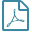

In [ ]:
df_law['Raw'][0]

As you can see, it is more readable in the column 'Text' than the column 'Raw'

In [ ]:
documents = [df_law['text'][i] for i in notebook.tqdm(range(len(df_law)))] 

  0%|          | 0/92177 [00:00<?, ?it/s]

In [ ]:
docs = [doc for doc in documents if len(doc.strip())> 0]

In [ ]:
del df_law

In [ ]:
df_law['Text'].str.len().describe()

count     92177.000000
mean      22929.625612
std       21280.127998
min           0.000000
25%        8999.000000
50%       17567.000000
75%       30762.000000
max      601566.000000
Name: Text, dtype: float64

in mean we have 92k caracters by documents. Some documents have 0 caracters, maybe we should remove them

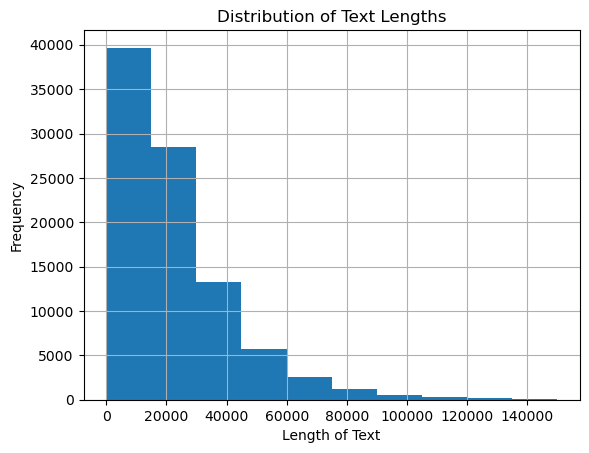

In [ ]:
len_char = df_law['Text'].str.len().copy()
len_char[len_char<150000].hist()

plt.title("Distribution of Text Lengths")
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.show()

Most Documents have less than 50k caracters

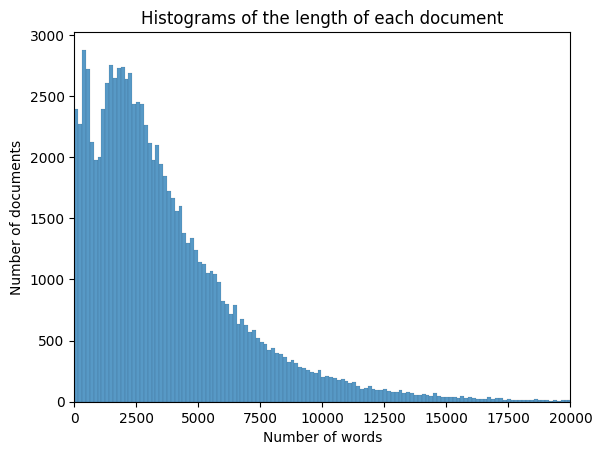

In [ ]:
word_count = df_law["text"].apply(lambda x : len(x.split(' ')))
  
ax = sns.histplot(word_count)
plt.xlim((0, 20000))
plt.title('Histograms of the length of each document')
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.show()

Most documents got less than 5000 words.

**Code from src**

In [ ]:
df_law["Datum"] = pd.to_datetime(df_law["Datum"])

<Axes: title={'center': 'Number of Legal Documents from 1992 to 2020'}, xlabel='Year', ylabel='Count'>

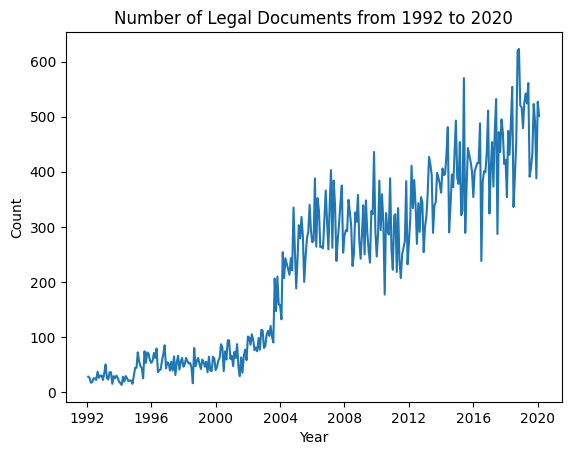

In [ ]:
year_month_count = df_law.groupby([df_law['Datum'].dt.year, df_law['Datum'].dt.month]).count().Datum
year_month_count.index.names = ['Year', 'Month']
year_month_count = year_month_count.reset_index()
year_month_count['Year & Month'] = pd.to_datetime(year_month_count.apply(lambda x : str(x['Year']) + '-' + str(x['Month']),axis=1))
year_month_count = year_month_count[year_month_count["Year & Month"] < "2020-03-01"]
year_month_count = year_month_count[year_month_count["Year & Month"] > "1992-01-01"]

ax = sns.lineplot(x = year_month_count['Year & Month'], y= year_month_count['Datum'])
plt.title("Number of Legal Documents from 1992 to 2020")
plt.ylabel("Count")
plt.xlabel("Year")
ax

From 2004, the number of documents increased and then stabilized starting 2016

**Code from src**

<ipython-input-24-39ce6d488b24>:7: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  year_month_count.pivot_table(index=year_month_count.Month, columns=year_month_count.Year).plot(colormap='Blues', figsize=(8,6), ylim=(0,720))


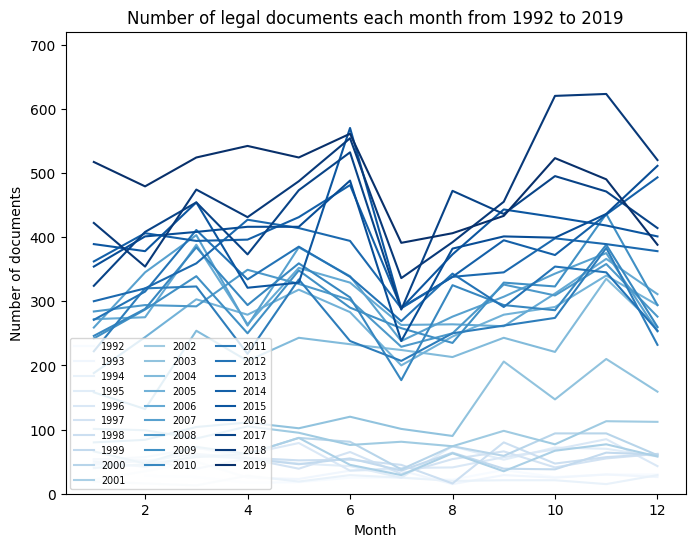

In [ ]:
year_month_count = df_law.groupby([df_law['Datum'].dt.year, df_law['Datum'].dt.month]).count().Datum
year_month_count.index.names = ['Year', 'Month']
year_month_count = year_month_count.reset_index()
year_month_count['Year & Month'] = pd.to_datetime(year_month_count.apply(lambda x : str(x['Year']) + '-' + str(x['Month']),axis=1))
year_month_count = year_month_count[year_month_count["Year & Month"] < "2020-01-01"]
year_month_count = year_month_count[year_month_count["Year & Month"] > "1992-01-01"]
year_month_count.pivot_table(index=year_month_count.Month, columns=year_month_count.Year).plot(colormap='Blues', figsize=(8,6), ylim=(0,720))
plt.legend(loc="lower left", fontsize="x-small", labels = range(1992,2020), ncol=3)
plt.title("Number of legal documents each month from 1992 to 2019")
plt.ylabel("Number of documents")
plt.show()

June and October seem to be the month where there are most of the documents

**Code from src**

<Axes: title={'center': 'Number of documents for each language in the scraped dataset'}, xlabel='Month', ylabel='Montly Count (log)'>

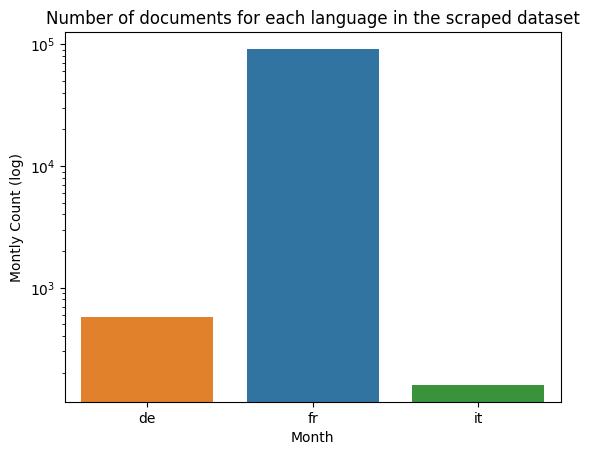

In [ ]:
language_count = df_law.groupby(df_law['Sprache']).count()._id
ax = sns.barplot(x = language_count.index, y = language_count.values, palette= ["tab:orange", "tab:blue", "tab:green"])
ax.set(xlabel= 'Month', ylabel='Montly Count (log)')
plt.title("Number of documents for each language in the scraped dataset")
ax.set_yscale('log')
ax

there is way more FR documents than DE and IT documents.

**Code from src**

## Frequences

In [ ]:
["l'art.", "Tribunal", "octobre", "janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre", "consid."] \
    +stopwords.words("french") + [letter.lower()+"______" for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]

["l'art.",
 'Tribunal',
 'octobre',
 'janvier',
 'février',
 'mars',
 'avril',
 'mai',
 'juin',
 'juillet',
 'août',
 'septembre',
 'octobre',
 'novembre',
 'décembre',
 'consid.',
 'au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',

This is the stop words list. All words don't have the same semantic importance...it is more interesting to remove most common word like "et", "etes", "mais"!; They are very common and we don't get any good information

In [ ]:
#@title Most Common
def get_most_common_ngrams(texts: list, ngram_min: int, ngram_sup: int) -> pd.DataFrame:
    """
    Returns the most common n-grams in a list of texts.

    Args:
    - texts (list): A list of strings to process.
    - ngram_min (int): The minimum n-gram size.
    - ngram_sup (int): The maximum n-gram size.

    Returns:
    - A pandas DataFrame with two columns: 'words' and 'count', sorted by count in descending order.
    """
    stop_word_fr = ["l'art.", "Tribunal", "octobre", "janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre", "consid."] \
    +stopwords.words("french") + [letter.lower()+"______" for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]

    # Create a CountVectorizer object with the desired n-gram range and stop words
    vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_sup), stop_words=stop_word_fr)
    # Fit and transform the input texts
    X = vectorizer.fit_transform(texts)

    # Get the n-gram names and their counts
    ngrams = vectorizer.get_feature_names_out()
    counts = X.toarray().sum(axis=0)

    res = [[count, ngram] for ngram, count in zip(ngrams, counts) if count > 0]

    res.sort(reverse=True)

    df_count = pd.DataFrame(res, columns=['count', 'words'])
    return df_count

In [ ]:
res = get_most_common_ngrams(docs[0:10], 1, 1)
print("-------------------- Most Common ---------------")
print(res.head(50))

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['art', 'consid', 'tribunal'] not in stop_words.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 19.50it/s]

-------------------- Most Common ---------------
words
fr              398
art             248
consid          214
tribunal        197
être            173
droit           152
al              150
décision        145
entretien       139
mme             125
2014            121
fédéral         119
frais           118
cour            117
fait            117
juge            111
recours         111
cette           109
procédure       108
intimé          107
000             106
pouvoir         101
appelante       101
ci               96
parties          90
plus             89
mois             88
judiciaire       86
peut             84
atf              83
si               82
appel            80
arrêt            78
ainsi            77
enfants          75
charge           75
deux             72
lors             72
enfant           71
cpc              71
doit             67
selon            65
contribution     65
2013             65
______           65
iii              64
effet            64
génér

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer


def get_most_common_ngrams(texts: list, ngram_min: int, ngram_sup: int, batch_size: int = 10000) -> pd.DataFrame:
    """
    Returns the most common n-grams in a list of texts.

    Args:
    - texts (list): A list of strings to process.
    - ngram_min (int): The minimum n-gram size.
    - ngram_sup (int): The maximum n-gram size.
    - batch_size (int): The number of texts to process in each batch.

    Returns:
    - A pandas DataFrame with two columns: 'words' and 'count', sorted by count in descending order.
    """

    # Create a CountVectorizer object with the desired n-gram range and stop words
    stop_word_fr = ["l'art.", "Tribunal", "octobre", "janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre", "consid."] \
    +stopwords.words("french") + [letter.lower()+"______" for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]

    vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_sup), stop_words=stop_word_fr)

    res = []

    # Process the texts in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        # Get the current batch of texts
        batch = texts[i:i+batch_size]
        # Fit and transform the current batch of texts
        X = vectorizer.fit_transform(batch)
        # Get the n-gram names and their counts for the current batch
        ngrams = vectorizer.get_feature_names_out()
        counts = X.toarray().sum(axis=0)
        # Append the n-grams and their counts for the current batch to the results list
        res += [[count, ngram] for ngram, count in zip(ngrams, counts) if count > 0]

    # Sort the results by count in descending order
    # res.sort(reverse=True)

    # Create a pandas DataFrame from the results
    df_count = pd.DataFrame(res, columns=['count', 'words'])
    
    df_result = df_count.groupby('words')['count'].sum()
    return df_result.sort_values(ascending = False)


In [ ]:
res = get_most_common_ngrams(docs[0:10], 1, 1)
print("-------------------- Most Common ---------------")
print(res.head(50))

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['art', 'consid', 'tribunal'] not in stop_words.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 20.61it/s]

-------------------- Most Common ---------------
words
fr              398
art             248
consid          214
tribunal        197
être            173
droit           152
al              150
décision        145
entretien       139
mme             125
2014            121
fédéral         119
frais           118
cour            117
fait            117
juge            111
recours         111
cette           109
procédure       108
intimé          107
000             106
pouvoir         101
appelante       101
ci               96
parties          90
plus             89
mois             88
judiciaire       86
peut             84
atf              83
si               82
appel            80
arrêt            78
ainsi            77
enfants          75
charge           75
deux             72
lors             72
enfant           71
cpc              71
doit             67
selon            65
contribution     65
2013             65
______           65
iii              64
effet            64
génér

Good for the safety check. Same result with batch and without a batch

In [ ]:
#@title IDF
from sklearn.feature_extraction.text import TfidfVectorizer

def idf_sklearn(word, documents, n_low, n_high):
    vectorizer = TfidfVectorizer(use_idf=True,  ngram_range=(n_low, n_high))
    tfidf_matrix = vectorizer.fit_transform(documents)
    idf = vectorizer.idf_[vectorizer.vocabulary_[word]]
    return idf


In [ ]:
# @title Unigrams
res = get_most_common_ngrams(docs, 1, 1)
print("-------------------- Most Common ---------------")
print(res.head(50))

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['art', 'consid', 'tribunal'] not in stop_words.
  warnings.warn(
100%|██████████| 9/9 [05:03<00:00, 33.77s/it]


-------------------- Most Common ---------------
words
art           1971418
être          1255418
al            1123484
tribunal      1122525
consid        1092826
recours       1031558
droit          975409
décision       965839
cette          763709
fr             734825
fait           683167
ainsi          646874
ci             642868
fédéral        632159
plus           631236
recourant      627792
arrêt          590104
procédure      566875
selon          562054
si             558431
atf            548373
doit           531446
peut           526575
cas            509340
après          503315
travail        488442
loi            467194
comme          458406
dès            434497
________       433428
sans           422135
frais          419045
endif          409149
if             408967
compte         395281
lors           392779
cause          389640
contre         386738
non            383284
recourante     382585
deux           379478
suisse         378642
1er            370698

More interesting when we need to remove more stopwords...

In [ ]:
# @title Bigrams
res = get_most_common_ngrams(docs, 2, 2, 1000)
print("-------------------- Most Common ---------------")
print(res.head(50))

100%|██████████| 90/90 [15:49<00:00, 10.55s/it]


-------------------- Most Common ---------------
words
tribunal fédéral          512199
endif if                  408626
doit être                 242921
ci après                  222573
dès lors                  197363
al let                    190544
peut être                 173560
arrêt tribunal            166722
présent arrêt             156987
assurances sociales       154827
loi fédérale              144066
celle ci                  143530
000 fr                    134421
celui ci                  132771
art al                    128629
tribunal administratif    120538
première instance         120022
moyens preuve             118908
selon art                 117818
sens art                  110393
cour justice              105875
autorité intimée          105469
mesure où                 105191
doivent être              104306
1er janvier               101609
décision attaquée          99032
autorisation séjour        95808
capacité travail           95533
compte tenu          

"end if" I have to separate languages ?!

In [ ]:
# @title Trigrams
res = get_most_common_ngrams(documents, 3, 3, 1000)
print("-------------------- Most Common ---------------")
print(res.head(50))

100%|██████████| 93/93 [24:43<00:00, 15.95s/it]


-------------------- Most Common ---------------
words
arrêt tribunal fédéral          154975
17 juin 2005                     69656
rs 173 110                       68455
ltf rs 173                       65871
recours doit être                56931
tribunal fédéral 17              52550
adressé tribunal fédéral         52535
fédéral 17 juin                  52304
juin 2005 ltf                    52150
doit être adressé                50492
être adressé tribunal            49700
2005 ltf rs                      48926
mémoire recours doit             48783
matière droit public             46778
recours matière droit            46704
comme moyens preuve              45787
preuve doivent être              45677
chambre assurances sociales      45509
invoquées comme moyens           45345
arrêts tribunal fédéral          45189
moyens preuve doivent            44902
cour justice chambre             44871
tribunal première instance       44858
indiquer conclusions motifs      44429
droit adm

very interesting trigrams. We could use them to detect types of case law: "matière droit public", "cour droit administratif"

# Conclusion

Using Batches seems to solve the memory issues. Pandaparallel is very effective with TPU machine